In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *

In [4]:
import librosa

In [5]:
DATA = Path('data')
NSYNTH_AUDIO = DATA/'nsynth_audio' # contains train and valid folders

In [6]:
LABEL_DIR = Path('tmp_labels')
GUITAR_TRN = LABEL_DIR/'train_guitar_clean_40_88.csv'
GUITAR_VAL = LABEL_DIR/'valid_guitar_clean_40_88.csv'
GUITAR_TST = LABEL_DIR/'test_guitar_clean_40_88.csv'

In [7]:
trn_df, val_df, tst_df = [pd.read_csv(CSV) for CSV in [GUITAR_TRN, GUITAR_VAL, GUITAR_TST]]
trn_df.head(2)

,note_str,pitch
0,guitar_acoustic_001-082-050,82
1,guitar_electronic_035-062-127,62


In [8]:
len(trn_df), len(val_df), len(tst_df)

(16915, 1112, 347)

In [9]:
tst_df.head()

,note_str,pitch
0,guitar_acoustic_010-066-100,66
1,guitar_acoustic_014-070-050,70
2,guitar_acoustic_015-068-127,68
3,guitar_acoustic_021-045-025,45
4,guitar_electronic_022-053-075,53


In [10]:
trn_list, val_list, tst_list = [AudioItemList.from_df(df, path=NSYNTH_AUDIO, 
                                                      folder=folder, suffix='.wav')
                                for df, folder in zip([trn_df, val_df, tst_df], 
                                                      ['train', 'valid', 'test'])]
len(trn_list), len(val_list), len(tst_list)

(16915, 1112, 347)

In [11]:
clips = trn_list[:5]

In [12]:
x = clips[0].data.numpy()
sr = 16000

In [13]:
from IPython.display import Audio
Audio(x, rate=sr)

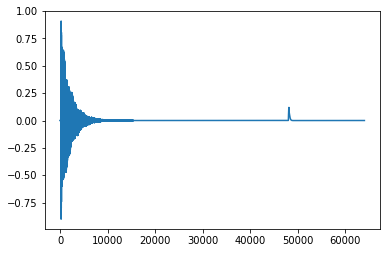

In [14]:
plt.plot(x)

(31700,) (7680,)
[   0 7680]


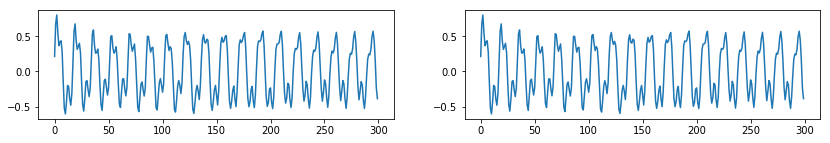

In [15]:
x1 = x[300:sr*2]
x2, idx = librosa.effects.trim(x1, ref=1.0, top_db=40)
print(x1.shape, x2.shape)
print(idx)

fig, ax = plt.subplots(1,2, figsize=(14,2))
ax[0].plot(x1[:300])
ax[1].plot(x2[:300])

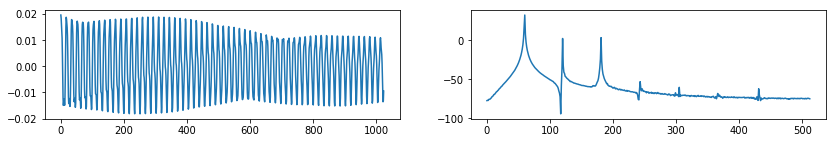

In [16]:
fig, ax = plt.subplots(1,2, figsize=(14,2))

frame = x2[-1024:]
spec = librosa.amplitude_to_db(abs(np.fft.rfft(frame) ** 2), ref=1.0, top_db=None)
ax[0].plot(frame)
ax[1].plot(spec)

In [17]:
x2.shape

(7680,)

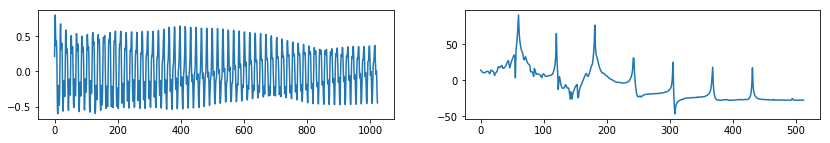

In [18]:
fig, ax = plt.subplots(1,2, figsize=(14,2))

frame = x2[:1024]
spec = librosa.amplitude_to_db(abs(np.fft.rfft(frame) ** 2), ref=1.0, top_db=None)
ax[0].plot(frame)
ax[1].plot(spec)

In [ ]:
x1.shape

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,2))

frame_len = 1024
s = 16000
frame = x1[s:s+frame_len]
spec = librosa.amplitude_to_db(abs(np.fft.rfft(frame) ** 2), ref=1.0, top_db=None)
# spec[spec < 0] = 0.0
ax[0].plot(frame)
ax[1].plot(spec)

In [ ]:
def split_into_arrays(x, frame_len=1024):
    n_frames = x.shape[0] // frame_len
    frames = [x[n * frame_len:(n+1) * frame_len] for n in range(n_frames)]
    return frames

In [ ]:
frames = split_into_arrays(x1)
len(frames)

In [ ]:
plt.plot(frames[0])


In [ ]:
plt.plot(frames[1])


In [19]:
from utils import read_file

In [20]:
from tqdm import tqdm_notebook as tqdm

In [22]:
df = trn_df.copy()

trimmed = []
lengths = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    filename = NSYNTH_AUDIO/'train'/(row['note_str'] + '.wav')
    x, _ = read_file(filename)
    offset = 300
    max_len = sr * 2
    x, idx = librosa.effects.trim(x[offset:offset+max_len], ref=1.0, top_db=40)
    trimmed.append(x)
    lengths.append(x.shape[0])

df['trimmed'] = trimmed
df['length'] = lengths

In [23]:
note_strs = []
pitches = []
frames = []

frame_len = 1024

for _, row in tqdm(df.iterrows(), total=len(df)):
    n_frames = row.length // frame_len
    for i in range(n_frames):
        note_strs.append(row.note_str)
        pitches.append(row.pitch)
        offset = i*frame_len
        frame = row.trimmed[offset:offset+frame_len]
        frames.append(frame)

        
frame_df = pd.DataFrame({'note_str': note_strs, 'pitch': pitches, 'frame': frames})
frame_df.head()

,note_str,pitch,frame
0,guitar_acoustic_001-082-050,82,"[0.21124913, 0.66933197, 0.79961544, 0.5485702..."
1,guitar_acoustic_001-082-050,82,"[-0.40995514, -0.238258, -0.020447401, 0.09100..."
2,guitar_acoustic_001-082-050,82,"[-0.10788293, -0.15909299, -0.13910337, -0.117..."
3,guitar_acoustic_001-082-050,82,"[0.099490345, 0.059938353, 0.052095097, 0.0681..."
4,guitar_acoustic_001-082-050,82,"[-0.0129703665, -0.014099551, -0.009033479, 0...."


In [24]:
frame_df.shape

(401283, 3)

In [30]:
fl = AudioFrameList.from_df(frame_df, NSYNTH_AUDIO, cols=2)
fl[0].data.shape

torch.Size([1024])

In [32]:
rows = [
    (1, 'test', []),
    (2, 'test2', [1,]),
    (4, 'test1', [3,3])
]

In [35]:
pd.DataFrame(rows, columns=['num', 'str', 'list'])

,num,str,list
0,1,test,[]
1,2,test2,[1]
2,4,test1,"[3, 3]"


In [60]:
def load_trim_split(df, path, suffix='.wav', offset=300, max_len=32000, top_db=40, frame_len=1024):
    rows = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        filename = row['note_str'] + '.wav'
        x, _ = read_file(filename, path=path)
        x = x[offset:offset+max_len]
        x = librosa.effects.trim(x, ref=1.0, top_db=top_db)[0]

        n_frames = max(x.shape[0] // frame_len, 1)
        frames = [x[n*frame_len:(n+1)*frame_len] 
                  for n in range(n_frames)]
        
        for frame in frames:
            row = row.copy()
            row['frame'] = frame
            rows.append(row)
        
        if len(frames) == 0:
            import pdb; pdb.set_trace()

    return pd.DataFrame(rows)
    
trn_frames = load_trim_split(trn_df, NSYNTH_AUDIO/'train', max_len=sr*2)
print(trn_frames.shape)
trn_frames.head()

(401348, 3)


,note_str,pitch,frame
0,guitar_acoustic_001-082-050,82,"[0.21124913, 0.66933197, 0.79961544, 0.5485702..."
0,guitar_acoustic_001-082-050,82,"[-0.40995514, -0.238258, -0.020447401, 0.09100..."
0,guitar_acoustic_001-082-050,82,"[-0.10788293, -0.15909299, -0.13910337, -0.117..."
0,guitar_acoustic_001-082-050,82,"[0.099490345, 0.059938353, 0.052095097, 0.0681..."
0,guitar_acoustic_001-082-050,82,"[-0.0129703665, -0.014099551, -0.009033479, 0...."


In [58]:
val_frames = load_trim_split(val_df, NSYNTH_AUDIO/'valid', max_len=sr*2)

In [61]:
trn_frames.shape, val_frames.shape

((401348, 3), (30964, 3))

In [62]:
trn_list = AudioFrameList.from_df(trn_frames, NSYNTH_AUDIO, cols=2)
val_list = AudioFrameList.from_df(trn_frames, NSYNTH_AUDIO, cols=2)

In [74]:
to_db = ToDecibels(ref=1.0, top_db=50.0)
window = to_device(torch.hann_window(1024).unsqueeze_(0), None)

def batch_fft(inputs):
    xs, ys = inputs
    xs = torch.rfft(xs * window, 1, normalized=True).pow_(2.0).sum(-1)
    xs = to_db(xs)
    return xs, ys

batch_tfms = [batch_fft]

In [78]:
bs = 32
data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitch')
            .databunch(bs=bs, tfms=batch_tfms))
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([32, 513]), torch.Size([32]))

In [73]:
data.c

48